In [2]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt

dataroot = '../WaterLevelPrediction_SelectingModel//Data/'

In [3]:
df = pd.read_pickle(dataroot+'finaldata.pkl')

Cross Validation

In [4]:
from sklearn.model_selection import TimeSeriesSplit

tss = TimeSeriesSplit(n_splits=6, test_size=365)
df = df.sort_index()

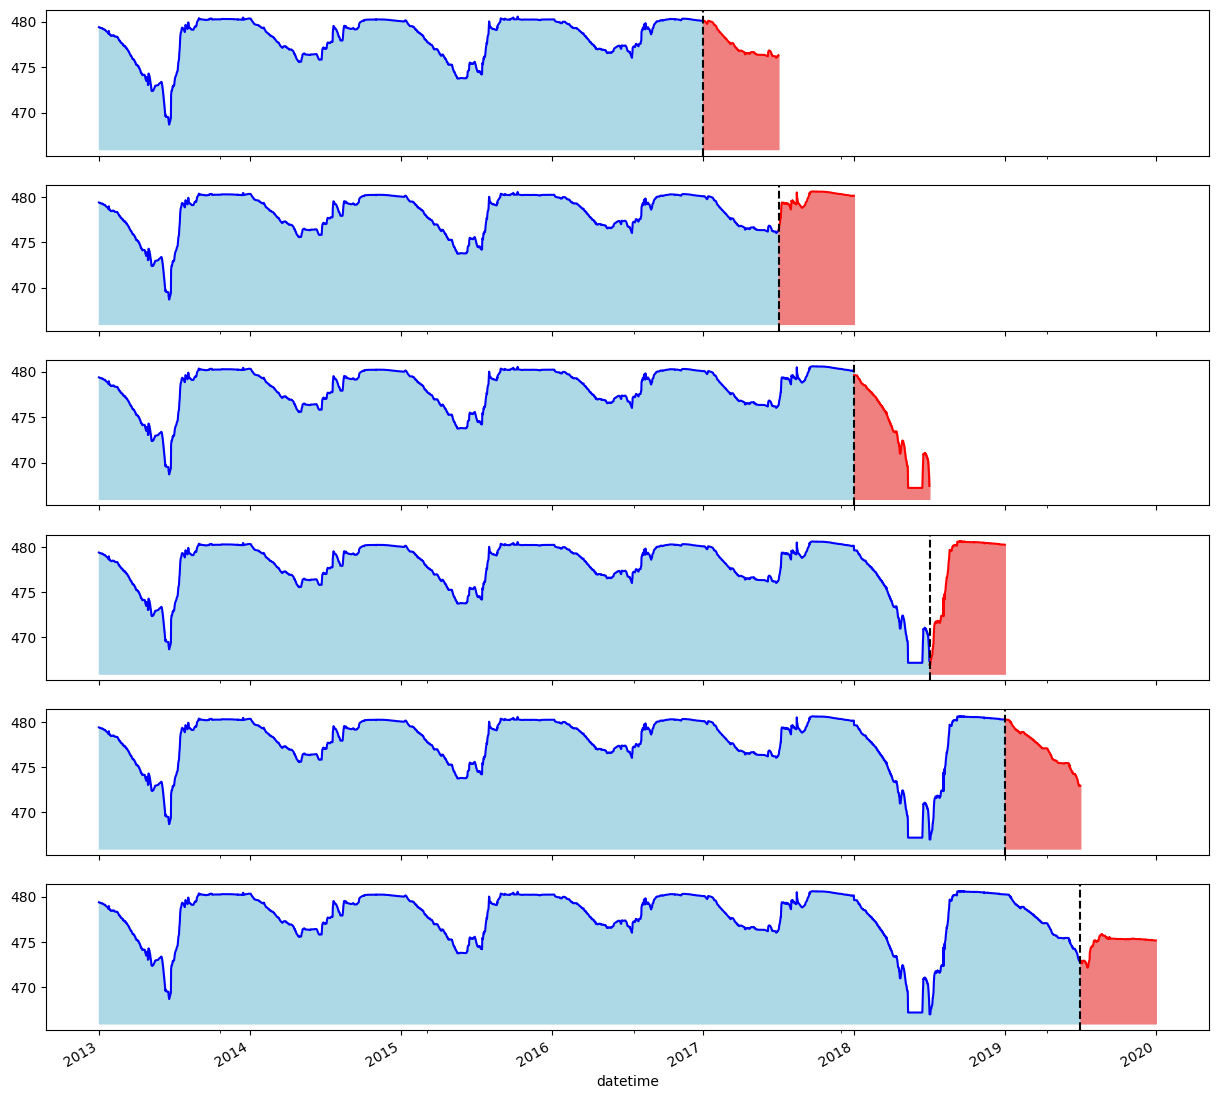

In [5]:
fig, axs = plt.subplots(6,1, figsize = (15,15), sharex=True)

fold = 0
for train_idx, val_idx in tss.split(df):
    train = df.iloc[train_idx]
    test = df.iloc[val_idx]
    train['water_level'].plot(ax=axs[fold],
                              label='Tập huấn luyện',
                              color='blue')
    test['water_level'].plot(ax=axs[fold],
                             label='Tập kiểm thử',
                             color='red')
    axs[fold].fill_between(train.index,466, train['water_level'], color='lightblue')
    axs[fold].fill_between(test.index,466, test['water_level'], color='lightcoral')
    axs[fold].axvline(test.index.min(), color='black', ls='--')
    fold+=1
plt.show()

Train the model with first features set

In [6]:
from sklearn.ensemble import RandomForestRegressor

fold = 0
preds = []
rmses = []
maes = []
r2s = []
for train_idx, val_idx in tss.split(df):
    train = df.iloc[train_idx]
    test = df.iloc[val_idx]
    
    features = ['precipitation','sluice_status']
    target = 'water_level'
    
    X_train = train[features]
    y_train = train[target]
    
    X_test = test[features]
    y_test = test[target]
    
    rf_reg = RandomForestRegressor()
    rf_reg.fit(X_train, y_train)
    
    y_pred = rf_reg.predict(X_test)
    preds.append(y_pred)
    rmse = np.sqrt(mean_squared_error(y_test,y_pred))
    rmses.append(rmse)
    mae = mean_absolute_error(y_test,y_pred)
    maes.append(mae)
    r2 = r2_score(y_test,y_pred)
    r2s.append(r2)

Model and Fold score

In [7]:
print(f'mean squared error across fold:{np.mean(rmses)}')
print(f'score for each fold:{rmses}')
print(f'mean absolute error across fold:{np.mean(maes)}')
print(f'score for each fold:{maes}')
print(f'r2 score across fold:{np.mean(r2s)}')
print(f'score for each fold:{r2s}')

mean squared error across fold:3.197129285851094
score for each fold:[1.9571520651465997, 1.6009331566451852, 6.328679117361478, 3.845968038827631, 2.2793180725567512, 3.170725264568914]
mean absolute error across fold:2.6867892631653043
score for each fold:[1.7058402731857367, 1.4336719884869082, 4.838595456624846, 3.2171214256971625, 1.9247056736302168, 3.000800761366955]
r2 score across fold:-2.8969036660989436
score for each fold:[-1.0939985774355665, -3.085018133943189, -1.2209949675283394, 0.03564223245306508, -0.3739984233679505, -11.643054126771682]


Plot for Model Performance

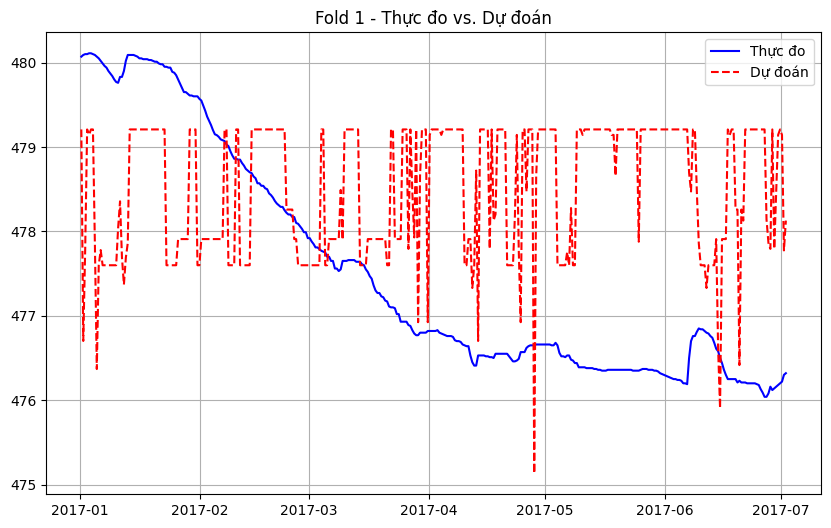

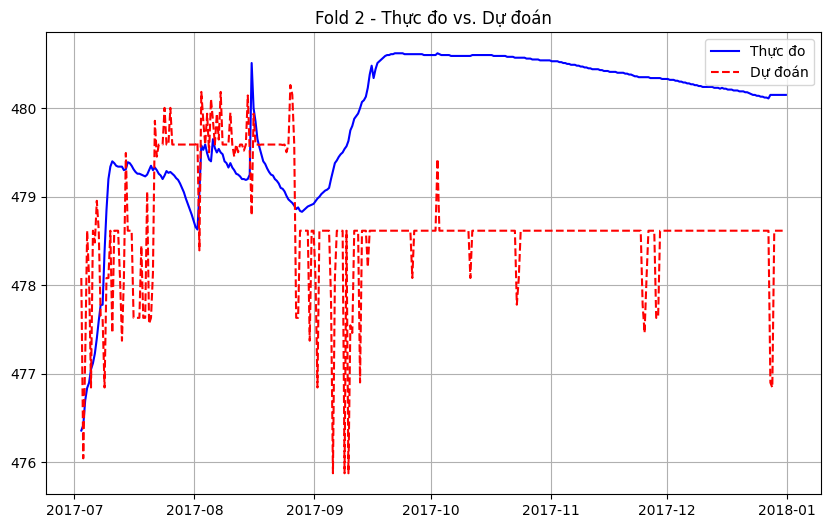

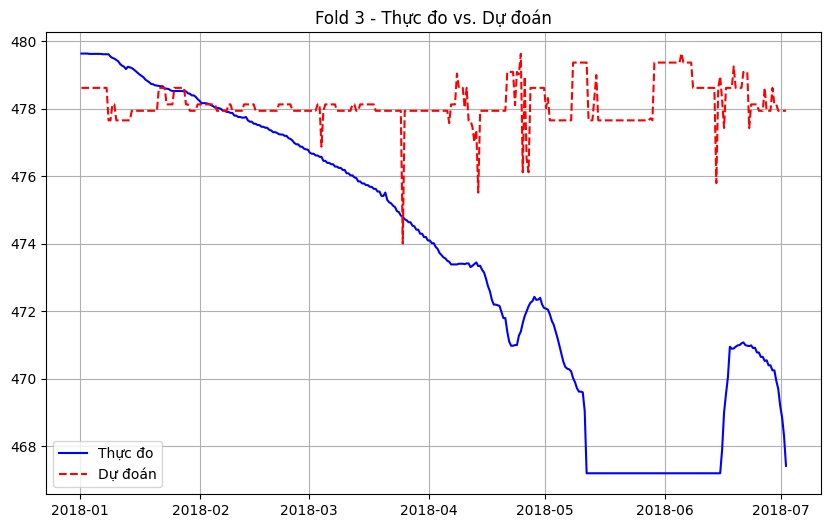

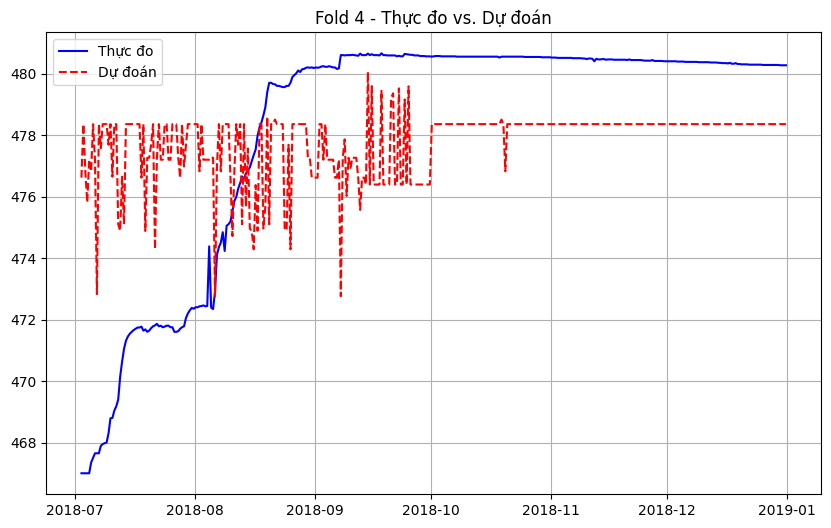

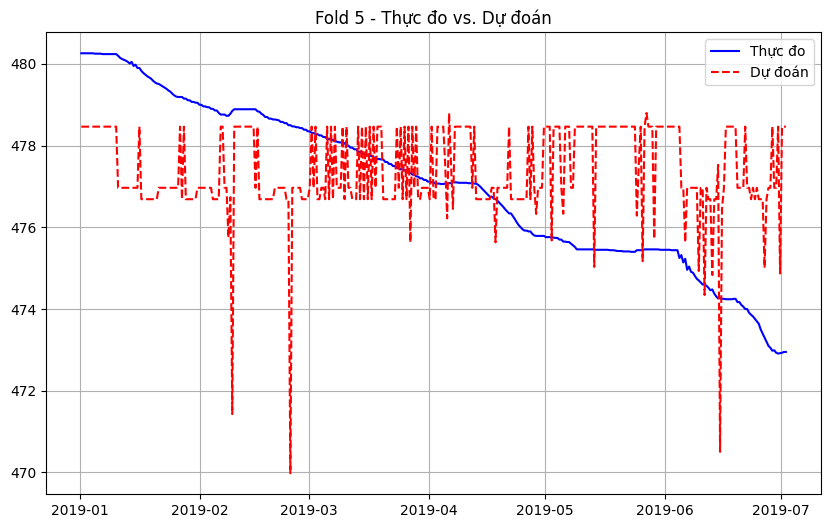

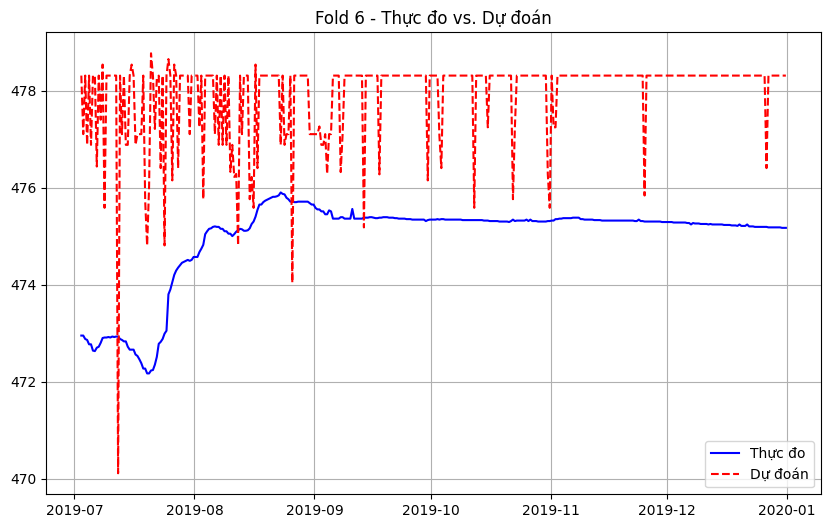

In [8]:
fold = 0
for train_idx, val_idx in tss.split(df):
    train = df.iloc[train_idx]
    test = df.iloc[val_idx]

    plt.figure(figsize=(10, 6))
    plt.plot(test.index, test['water_level'], label='Thực đo', color='blue')
    plt.plot(test.index, preds[fold], label='Dự đoán', color='red', linestyle='dashed')
    fold += 1

    plt.title('Fold {} - Thực đo vs. Dự đoán'.format(fold))

    plt.legend()
    plt.grid()
    plt.show()

Create Lag Feature

In [9]:
def add_lag(df):
    target_map = df['water_level'].to_dict() # mapping water level
    df['lag'] = (df.index - pd.Timedelta('12 hours')).map(target_map)# lag 12 hours
    return df

df = add_lag(df)
df = df.dropna(subset=['lag'])# drop the NaN value because model won't accept it
df.head()

,year,month,day,water_level,hour,precipitation,sluice_status,datetime,lag
datetime,,,,,,,,,
2013-01-01 19:00:00,2013,1,1,479.38,19,0.0,0,2013-01-01 19:00:00,479.40
2013-01-02 07:00:00,2013,1,2,479.37,7,0.0,5,2013-01-02 07:00:00,479.38
2013-01-02 19:00:00,2013,1,2,479.36,19,0.0,5,2013-01-02 19:00:00,479.37
2013-01-03 07:00:00,2013,1,3,479.36,7,0.0,5,2013-01-03 07:00:00,479.36
2013-01-03 19:00:00,2013,1,3,479.36,19,0.0,5,2013-01-03 19:00:00,479.36


Retrain the model with second feature set

In [10]:
fold = 0
preds = []
rmses = []
maes = []
r2s = []
for train_idx, val_idx in tss.split(df):
    train = df.iloc[train_idx]
    test = df.iloc[val_idx]
    
    features = ['precipitation','sluice_status','lag']
    target = 'water_level'
    
    X_train = train[features]
    y_train = train[target]
    
    X_test = test[features]
    y_test = test[target]
    
    rf_reg = RandomForestRegressor()
    rf_reg.fit(X_train, y_train)
    
    y_pred = rf_reg.predict(X_test)
    preds.append(y_pred)
    rmse = np.sqrt(mean_squared_error(y_test,y_pred))
    rmses.append(rmse)
    mae = mean_absolute_error(y_test,y_pred)
    maes.append(mae)
    r2 = r2_score(y_test,y_pred)
    r2s.append(r2)

In [11]:
print(f'mean squared error across fold:{np.mean(rmses)}')
print(f'score for each fold:{rmses}')
print(f'mean absolute error across fold:{np.mean(maes)}')
print(f'score for each fold:{maes}')
print(f'r2 score across fold:{np.mean(r2s)}')
print(f'score for each fold:{r2s}')

mean squared error across fold:0.23048212857176867
score for each fold:[0.052302498498221994, 0.15540473263772786, 0.7835094768176692, 0.22323865786048006, 0.09048546621799666, 0.07795193939851609]
mean absolute error across fold:0.12557176964710584
score for each fold:[0.033751716242632686, 0.10527306019365705, 0.4042124705639633, 0.12011987756827366, 0.045135631814995365, 0.04493786149911283]
r2 score across fold:0.9854857135725489
score for each fold:[0.9985045492571065, 0.9615075041911123, 0.9659584027200726, 0.996750880781935, 0.9978346204888726, 0.9923583239961948]


Hyperparameter Tuning

In [12]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [100, 150, 200],
    'max_depth': [None, 5, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap' : [True, False],
    'max_features': [None, 'sqrt', 'log2'],
}

rf_reg = RandomForestRegressor()

grid_search = GridSearchCV(estimator=rf_reg, param_grid=param_grid, cv=tss)
grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_
print("Best Hyperparameters:", best_params)

Best Hyperparameters: {'bootstrap': True, 'max_depth': None, 'max_features': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 150}


In [16]:

fold = 0
preds = []
rmses = []
maes = []
r2s = []
for train_idx, val_idx in tss.split(df):
    train = df.iloc[train_idx]
    test = df.iloc[val_idx]
    
    features = ['precipitation','sluice_status','lag']
    target = 'water_level'
    
    X_train = train[features]
    y_train = train[target]
    
    X_test = test[features]
    y_test = test[target]
    
    rf_reg = RandomForestRegressor(n_estimators=best_params['n_estimators'],
                                   max_depth=best_params['max_depth'],
                                   max_features=best_params['max_features'],
                                   min_samples_leaf=best_params['min_samples_leaf'],
                                   min_samples_split=best_params['min_samples_split'],
                                   bootstrap=best_params['bootstrap'],
                                    n_jobs=-1
                                   )
    rf_reg.fit(X_train, y_train)
    
    y_pred = rf_reg.predict(X_test)
    preds.append(y_pred)
    rmse = np.sqrt(mean_squared_error(y_test,y_pred))
    rmses.append(rmse)
    mae = mean_absolute_error(y_test,y_pred)
    maes.append(mae)
    r2 = r2_score(y_test,y_pred)
    r2s.append(r2)

In [17]:
print(f'mean squared error across fold:{np.mean(rmses)}')
print(f'score for each fold:{rmses}')
print(f'mean absolute error across fold:{np.mean(maes)}')
print(f'score for each fold:{maes}')
print(f'r2 score across fold:{np.mean(r2s)}')
print(f'score for each fold:{r2s}')

mean squared error across fold:0.23384292700691378
score for each fold:[0.05272092352867773, 0.15446181878431234, 0.8056228321644874, 0.2213036084625222, 0.09208767514018208, 0.07686070396130124]
mean absolute error across fold:0.12726267101528274
score for each fold:[0.03362946079284347, 0.10444747052472347, 0.41455175189923066, 0.12007310415895016, 0.04463299334851343, 0.046241245367435284]
r2 score across fold:0.9852664094784455
score for each fold:[0.9984805260457138, 0.9619731913959148, 0.9640097424786533, 0.996806963874889, 0.9977572576495941, 0.9925707754259071]


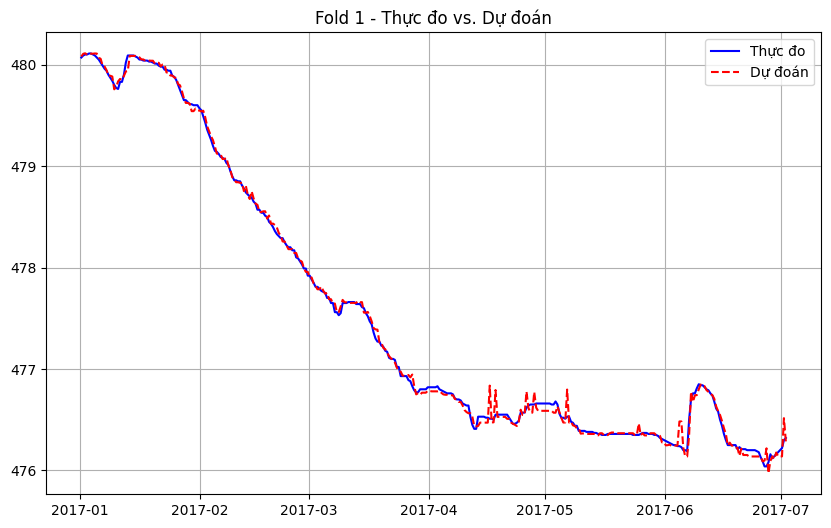

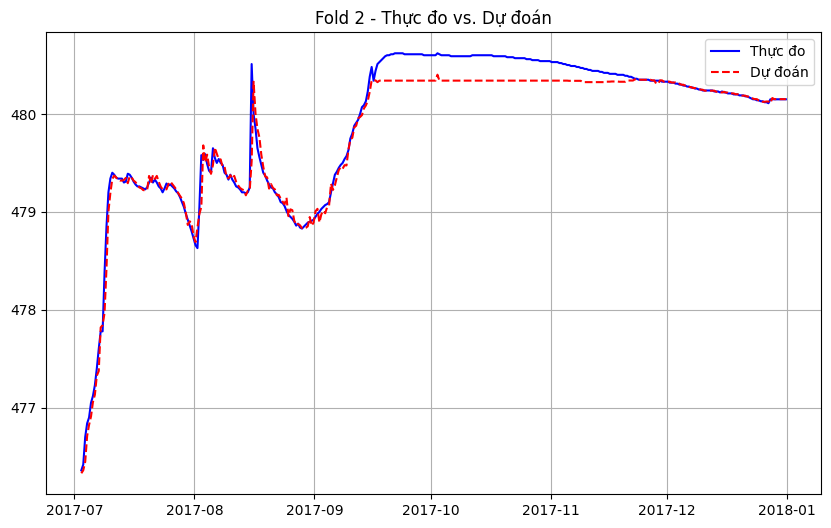

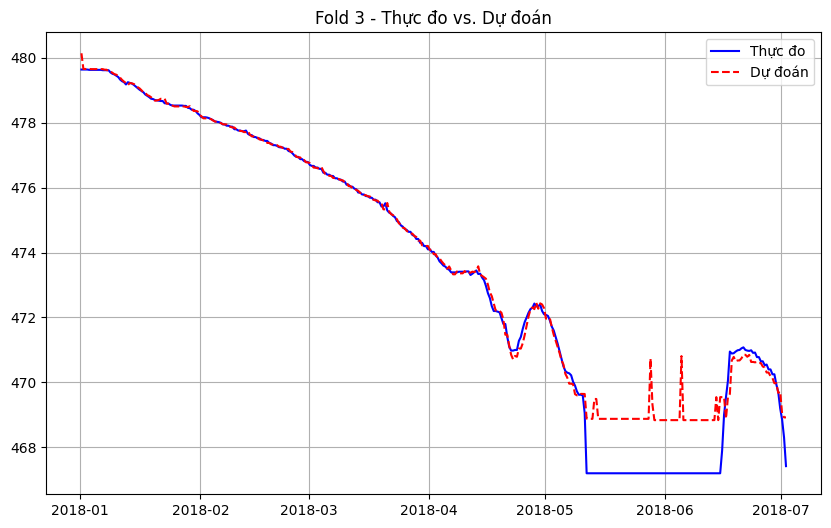

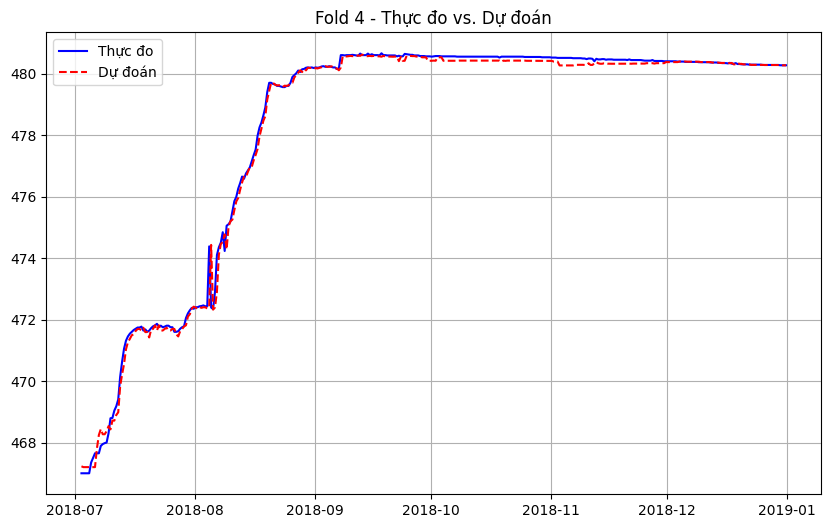

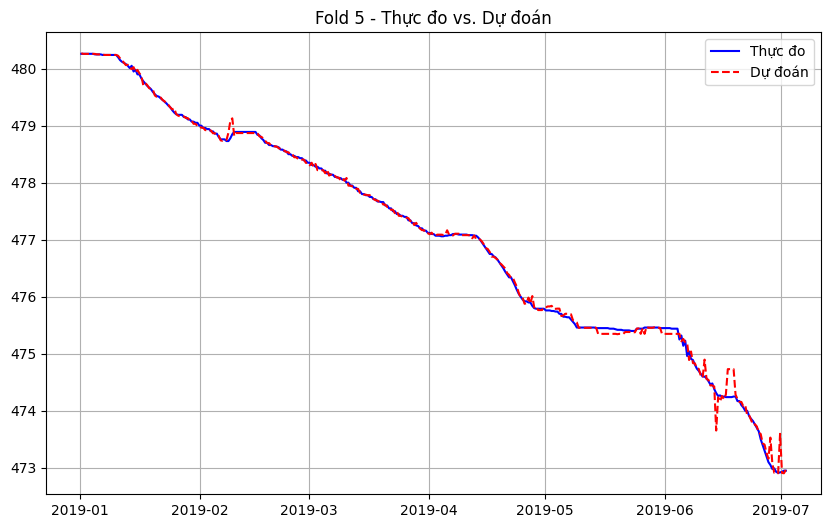

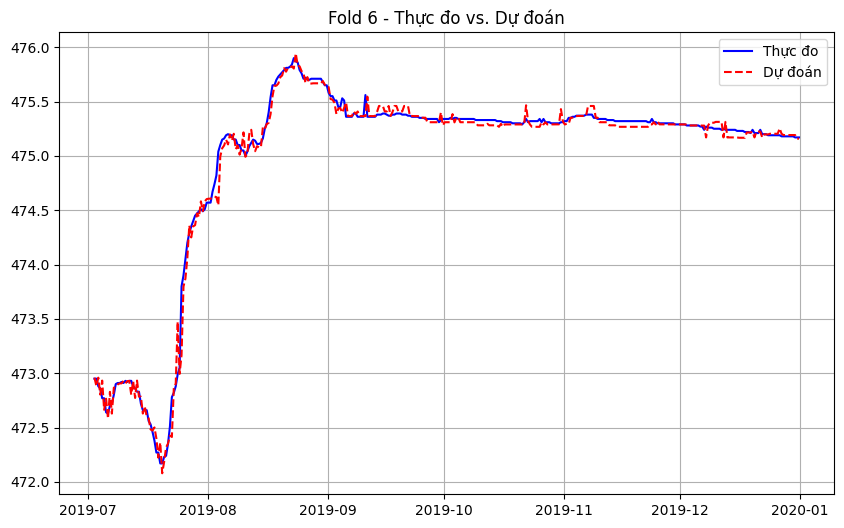

In [18]:
fold = 0
for train_idx, val_idx in tss.split(df):
    train = df.iloc[train_idx]
    test = df.iloc[val_idx]

    plt.figure(figsize=(10, 6))
    plt.plot(test.index, test['water_level'], label='Thực đo', color='blue')
    plt.plot(test.index, preds[fold], label='Dự đoán', color='red', linestyle='dashed')
    fold += 1

    plt.title('Fold {} - Thực đo vs. Dự đoán'.format(fold))

    plt.legend()
    plt.grid()
    plt.show()